# Conbine signals of 3M vol Swap (Start from 2010)
Vol Swap 3M, payoff = RV(3M) - IV(3M)

Rebalance every week (5 trading days)

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Load Data

In [12]:
directory = "h:/test_2005/"

trading_dates = pd.read_csv(directory + "trading_dates.csv", index_col=0)
trading_dates["MarketDate"] = pd.to_datetime(trading_dates["MarketDate"])

data = pd.read_csv(directory+"rolling_universe.csv", index_col=0)["Infocode"]
data.index = pd.to_datetime(data.index)
rolling_universe = {}
for key in data.index:
    rolling_universe[key] = np.array(data[key].split()).astype('int')
    
infocode_dict = pd.read_csv(directory + "infocode_dict.csv", index_col=0)["Ticker"].to_dict()

ticker_dict = pd.read_csv(directory + "ticker_dict.csv", index_col=0)["Infocode"].to_dict()

In [13]:
def read_stock_data(directory, name):
    stock_data = pd.read_csv(directory + name, index_col=0)
    stock_data.index = pd.to_datetime(stock_data.index)
    stock_data.columns = stock_data.columns.astype("int")
    return stock_data

In [14]:
stock_prices = read_stock_data(directory, 'stock_prices.csv')
stock_iv3m = read_stock_data(directory, 'stock_iv3m.csv')
stock_iv6m = read_stock_data(directory, 'stock_iv6m.csv')
stock_iv12m = read_stock_data(directory, 'stock_iv12m.csv')
stock_iv2m = read_stock_data(directory, 'stock_iv2m.csv')
stock_iv1m = read_stock_data(directory, 'stock_iv1m.csv')
stock_iv1m50delta = read_stock_data(directory, 'stock_iv1m50delta.csv')
stock_iv1m25delta = read_stock_data(directory, 'stock_iv1m25delta.csv')
stock_iv1m75delta = read_stock_data(directory, 'stock_iv1m75delta.csv')
stock_iv2m50delta = read_stock_data(directory, 'stock_iv2m50delta.csv')
stock_iv2m25delta = read_stock_data(directory, 'stock_iv2m25delta.csv')
stock_iv2m75delta = read_stock_data(directory, 'stock_iv2m75delta.csv')

In [15]:
stock_asset_per_equity = read_stock_data(directory, 'stock_asset_per_equity.csv')
stock_asset_per_marketcap = read_stock_data(directory, 'stock_asset_per_marketcap.csv')
stock_eps = read_stock_data(directory, 'stock_eps.csv')
stock_roe = read_stock_data(directory, 'stock_roe.csv')
stock_cps = read_stock_data(directory, 'stock_cps.csv')
stock_cpx_per_marketcap = read_stock_data(directory, 'stock_cpx_per_marketcap.csv')
stock_dps = read_stock_data(directory, 'stock_dps.csv')

In [16]:
trading_interval = 5
holding_period = 63

start_date = pd.to_datetime('20100101')
end_date = trading_dates["MarketDate"].iloc[-1]

rebalance_dates = []
valid_dates = trading_dates[(trading_dates["MarketDate"] >= start_date) & (trading_dates["MarketDate"] <= end_date)]
for i in range(0, len(valid_dates), trading_interval):
    rebalance_dates.append(valid_dates["MarketDate"].iloc[i])
    
trading_dates = list(pd.to_datetime(trading_dates["MarketDate"].values))

In [17]:
stock_returns = np.log(stock_prices/stock_prices.shift())

In [18]:
stock_rv1m = pd.rolling_std(stock_returns, 21) * np.sqrt(252)
stock_rv2m = pd.rolling_std(stock_returns, 42) * np.sqrt(252)
stock_rv3m = pd.rolling_std(stock_returns, 63) * np.sqrt(252)
stock_rv6m = pd.rolling_std(stock_returns, 126) * np.sqrt(252)
stock_rv12m = pd.rolling_std(stock_returns, 252) * np.sqrt(252)
stock_rv10d = pd.rolling_std(stock_returns, 10) * np.sqrt(252)

In [19]:
stock_delta1 = stock_prices - stock_prices.shift(1)
stock_gain = stock_delta1[stock_delta1>0]
stock_loss = np.abs(stock_delta1[stock_delta1<0])

def stock_rsi(N):
    return 100 * 1 / (1 + pd.rolling_mean(stock_loss, N, min_periods=0) / pd.rolling_mean(stock_gain, N, min_periods=0))

In [20]:
past_payoff = stock_rv3m - stock_iv3m.shift(63)

# Back Test Result

In [21]:
def backtest3m(score):
    daily_pnl = pd.Series(np.zeros(len(trading_dates)), index=trading_dates)
    for i in range(len(trading_dates)):
        date = trading_dates[i]
        #print date
        if (date in rebalance_dates) & (i + holding_period < len(trading_dates)):
            z = score.loc[date][rolling_universe[date]].dropna()
            z = (z-z.mean()) / z.std()
            z.sort(ascending=False)
            long_short = np.append(z.index[ : 1*len(z)/10], z.index[-(1*len(z)/10) : ])
            for infocode in long_short:
                if not np.isnan(stock_iv3m[infocode][date]):
                    daily_pnl[trading_dates[i+holding_period]] += np.sign(z[infocode]) * (stock_rv3m[infocode][trading_dates[i+holding_period]] - stock_iv3m[infocode][date])
    return daily_pnl


In [22]:
def sharpe_ratio(pnl):
    return pnl[pnl != 0].mean() / pnl[pnl != 0].std() * np.sqrt(12/3)

def pnl_mean(pnl):
    return pnl[pnl != 0].mean()

def pnl_std(pnl):
    return pnl[pnl != 0].std()

def hit_rate(pnl):
    return float(len(pnl[pnl > 0])) / len(pnl[pnl != 0])

def pnl_min(pnl):
    return pnl[pnl != 0].min()

def pnl_25perc(pnl):
    return pnl[pnl != 0].quantile(0.25)

def pnl_median(pnl):
    return pnl[pnl != 0].median()

def pnl_75perc(pnl):
    return pnl[pnl != 0].quantile(0.75)

def pnl_max(pnl):
    return pnl[pnl != 0].max()

def pnl_days(pnl):
    return len(pnl[pnl != 0])

In [23]:
def report_table(pnls, labels):
    result = pd.DataFrame(index = labels, columns=['Sharpe Ratio', 'PnL Mean', 'PnL Std', 'Hit Rate', 'PnL Min', 'PnL 25%Perc', 'PnL Median', 'PnL 75%Perc', 'PnL Max'])
    for i in range(len(pnls)):
        result.loc[labels[i]]['Sharpe Ratio'] = sharpe_ratio(pnls[i])
        result.loc[labels[i]]['PnL Mean'] = pnl_mean(pnls[i])
        result.loc[labels[i]]['PnL Std'] = pnl_std(pnls[i])
        result.loc[labels[i]]['Hit Rate'] = hit_rate(pnls[i])
        result.loc[labels[i]]['PnL Min'] = pnl_min(pnls[i])
        result.loc[labels[i]]['PnL 25%Perc'] = pnl_25perc(pnls[i])
        result.loc[labels[i]]['PnL Median'] = pnl_median(pnls[i])
        result.loc[labels[i]]['PnL 75%Perc'] = pnl_75perc(pnls[i])
        result.loc[labels[i]]['PnL Max'] = pnl_max(pnls[i])
    return result

# Combine Signal

In [24]:
def get_z_score(stock_data):
    stock_data[stock_data == np.inf] = np.nan
    z_score = stock_data.sub(stock_data.mean(axis=1),axis=0).div(stock_data.std(axis=1),axis=0)
    z_score = z_score[np.sort(z_score.columns)]
    return z_score

In [25]:
z_rviv13 = get_z_score(stock_rv1m - stock_iv3m)
#z_mom1 = get_z_score(pd.rolling_mean(past_payoff, 1))
#z_skew = get_z_score((stock_iv2m75delta - stock_iv2m25delta) / stock_iv1m50delta)
z_ts63 = get_z_score(- stock_iv3m + stock_iv6m)
z_bol18 = get_z_score(np.abs((stock_prices - pd.rolling_mean(stock_prices, 378)) / pd.rolling_std(stock_prices, 378)))
z_rsi6 = get_z_score(-stock_rsi(126))
z_cpx = stock_cpx_per_marketcap
payoff = stock_rv3m.shift(-63) - stock_iv3m

In [26]:
datasets = [z_rviv13, z_ts63, z_bol18, z_rsi6, z_cpx, payoff]

In [27]:
dates = list(pd.Series(index=trading_dates)[start_date : ].index)
available_infocodes = {}
for date in dates:
    st = set(rolling_universe[date])
    for i in range(len(datasets)):
        st = st & set(datasets[i].loc[date][datasets[i].loc[date].notnull()].index)
    available_infocodes[date] = np.sort(list(st))

In [28]:
Xy = np.array([])
date_index = pd.Series(index=dates)

for date in dates:
    if len(available_infocodes[date]) == 0:
        break
    new_Xy = datasets[0].loc[date][available_infocodes[date]].values
    for i in range(1, len(datasets)):
        new_Xy = np.c_[new_Xy, datasets[i].loc[date][available_infocodes[date]].values]
    if len(Xy) == 0:
        Xy = new_Xy
    else:
        Xy = np.r_[Xy, new_Xy]
    date_index[date] = Xy.shape[0]

In [29]:
Xy.shape

(837704, 6)

In [30]:
X = Xy[:, :-1]
y = Xy[:, -1:]

In [31]:
valid_date = pd.to_datetime('20151101')
test_date = pd.to_datetime('20170101')
valid_cut = int(date_index[valid_date:].iloc[0])
test_cut = int(date_index[test_date:].iloc[0])

X_train = X[: valid_cut]
y_train = np.sign(y[ : valid_cut])
X_test = X[valid_cut : test_cut]
y_test = np.sign(y[valid_cut : test_cut])

## Models:

In [32]:
models = {}
y_prob_test = {}
#model_names = ['lr', 'tree', 'rf', 'gbdt', 'ada']

### Linear Regression

In [33]:
from sklearn.linear_model import LinearRegression
models['linear'] = LinearRegression()
models['linear'].fit(X_train, np.sign(y_train))
print('train acc=', models['linear'].score(X_train, np.sign(y_train)))
print('test acc=', models['linear'].score(X_test, np.sign(y_test)))

('train acc=', 0.0085339647951522268)
('test acc=', 0.0022133370258503593)


### Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
models['lr'] = LogisticRegression(C=0.1)
models['lr'].fit(X_train, np.sign(y_train))
print('train acc=', models['lr'].score(X_train, np.sign(y_train)))
print('test acc=', models['lr'].score(X_test, np.sign(y_test)))
y_prob_test['lr'] = models['lr'].predict_proba(X_test)[:,-1]

('train acc=', 0.65122704626830807)
('test acc=', 0.62196009344720615)


### Decision Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier
models['tree'] = DecisionTreeClassifier(max_depth=6, max_features=None)
models['tree'].fit(X_train, np.sign(y_train))
print('train acc=', models['tree'].score(X_train, np.sign(y_train)))
print('test acc=', models['tree'].score(X_test, np.sign(y_test)))
y_prob_test['tree'] = models['tree'].predict_proba(X_test)[:,-1]

('train acc=', 0.65337991193297706)
('test acc=', 0.62339243996782967)


### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
models['rf'] = RandomForestClassifier(n_jobs=8, n_estimators=25, max_features='sqrt', max_depth=3)
models['rf'].fit(X_train, np.sign(y_train))
print('train acc=', models['rf'].score(X_train, np.sign(y_train)))
print('test acc=', models['rf'].score(X_test, np.sign(y_test)))
y_prob_test['rf'] = models['rf'].predict_proba(X_test)[:,-1]

('train acc=', 0.65196965418178898)
('test acc=', 0.62180690130596306)


### GBDT

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
models['gbdt'] = GradientBoostingClassifier(n_estimators=5, max_depth=2, max_features=None, learning_rate=0.2)
models['gbdt'].fit(X_train, np.sign(y_train))
models['gbdt'].score(X_test, np.sign(y_test))
print('train acc=', models['gbdt'].score(X_train, np.sign(y_train)))
print('test acc=', models['gbdt'].score(X_test, np.sign(y_test)))
y_prob_test['gbdt'] = models['gbdt'].predict_proba(X_test)[:,-1]

('train acc=', 0.65196965418178898)
('test acc=', 0.62180690130596306)


### AdaBoost

In [38]:
from sklearn.ensemble import AdaBoostClassifier
models['ada'] = AdaBoostClassifier(n_estimators = 30, learning_rate = 1.5)
models['ada'].fit(X_train, np.sign(y_train))
models['ada'].score(X_test, np.sign(y_test))
print('train acc=', models['ada'].score(X_train, np.sign(y_train)))
print('test acc=', models['ada'].score(X_test, np.sign(y_test)))
y_prob_test['ada'] = models['ada'].predict_proba(X_test)[:,-1]

('train acc=', 0.65221719015294932)
('test acc=', 0.62094902531500129)


## ROC Curve and AUC Score

In [58]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

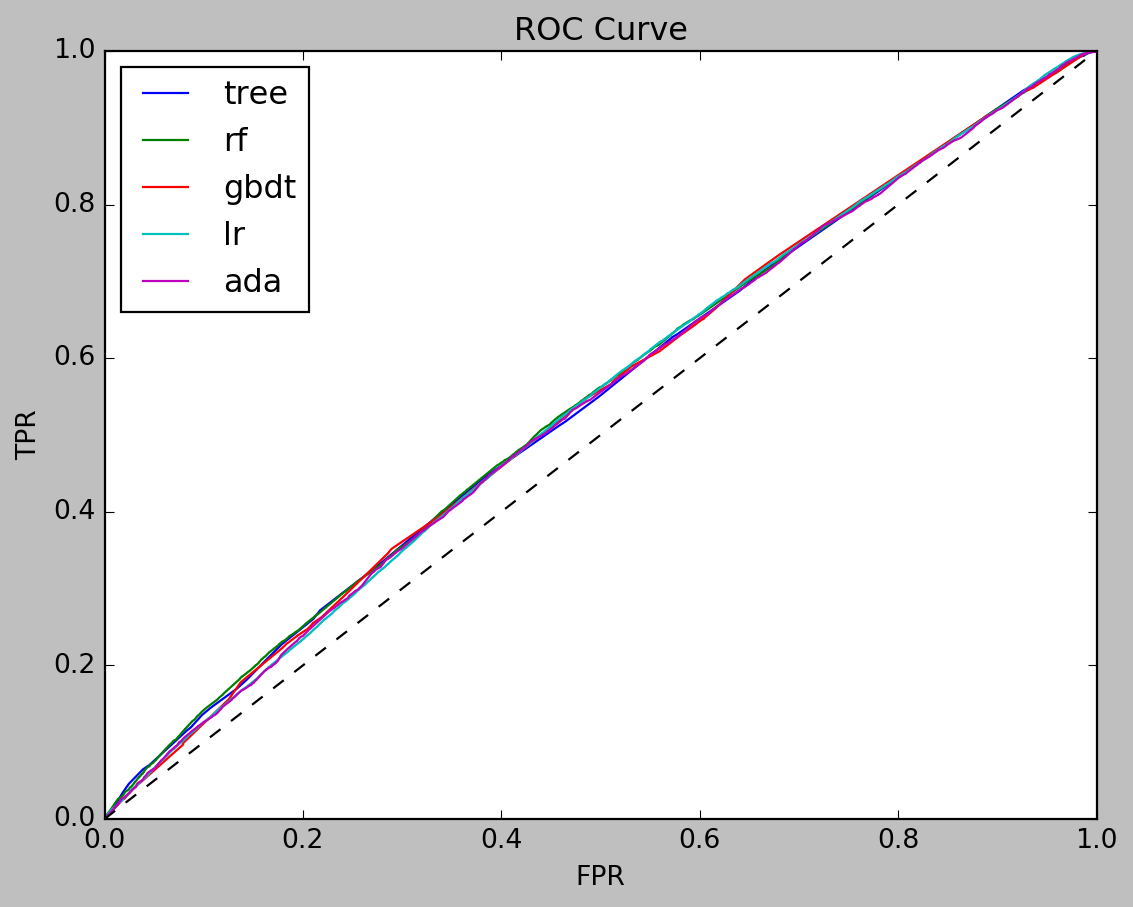

In [59]:
plt.figure(figsize=(8,6))
for model in y_prob_test:
    fpr, tpr, thresholds = roc_curve(np.sign(y_test).reshape(-1), y_prob_test[model])
    plt.plot(fpr, tpr, linewidth=1, label=model)
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1,0,1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='upper left', frameon=True)
plt.title("ROC Curve")
plt.show()

In [60]:
valid_auc = pd.Series()
for model in y_prob_test:
    valid_auc[model] = roc_auc_score(np.sign(y_test).reshape(-1), y_prob_test[model])
valid_auc.sort_values()

ada     0.539084
lr      0.540718
gbdt    0.541798
tree    0.542265
rf      0.544754
dtype: float64

## Back-test

In [61]:
def combine_signals(model, datasets, method='classification', startdate=dates[0], enddate=dates[-1]):
    alpha = pd.DataFrame(index=stock_prices.index, columns=stock_prices.columns)
    for date in dates:
        if (date >= startdate) and (date <= enddate):
            if len(available_infocodes[date]) == 0:
                break
            new_X = datasets[0].loc[date][available_infocodes[date]].values
            for i in range(1, len(datasets)-1):
                new_X = np.c_[new_X, datasets[i].loc[date][available_infocodes[date]].values]
            alpha.loc[date][available_infocodes[date]] = model.predict_proba(new_X)[:,1]
    return alpha

In [62]:
labels = ['lr', 'tree', 'rf', 'gbdt', 'ada']

In [63]:
alphas = {}
for label in labels:
    alphas[label] = combine_signals(models[label], datasets, startdate=test_date, enddate=dates[-1])

In [64]:
pnls = {}
for label in labels:
    pnls[label] = backtest3m(alphas[label])

In [65]:
for key in pnls:
    pnls[key] = pnls[key][pnls[key] != 0]

In [66]:
sharpe_ratios = {}
for key in pnls:
    sharpe_ratios[key] = pnls[key].mean() / pnls[key].std()*2

In [67]:
pd.Series(sharpe_ratios).sort_values()

tree    1.511278
gbdt    1.754080
ada     1.914009
rf      2.227624
lr      2.841893
dtype: float64

In [ ]:
alphas = {}
for label in labels:
    alphas[label] = combine_signals(models[label], datasets, startdate=valid_date, enddate=test_date)

In [ ]:
pnls = {}
for label in labels:
    pnls[label] = backtest3m(alphas[label])

In [ ]:
for key in pnls:
    pnls[key] = pnls[key][pnls[key] != 0]

In [ ]:
sharpe_ratios = {}
for key in pnls:
    sharpe_ratios[key] = pnls[key].mean() / pnls[key].std()*2

In [ ]:
pd.Series(sharpe_ratios).sort_values()

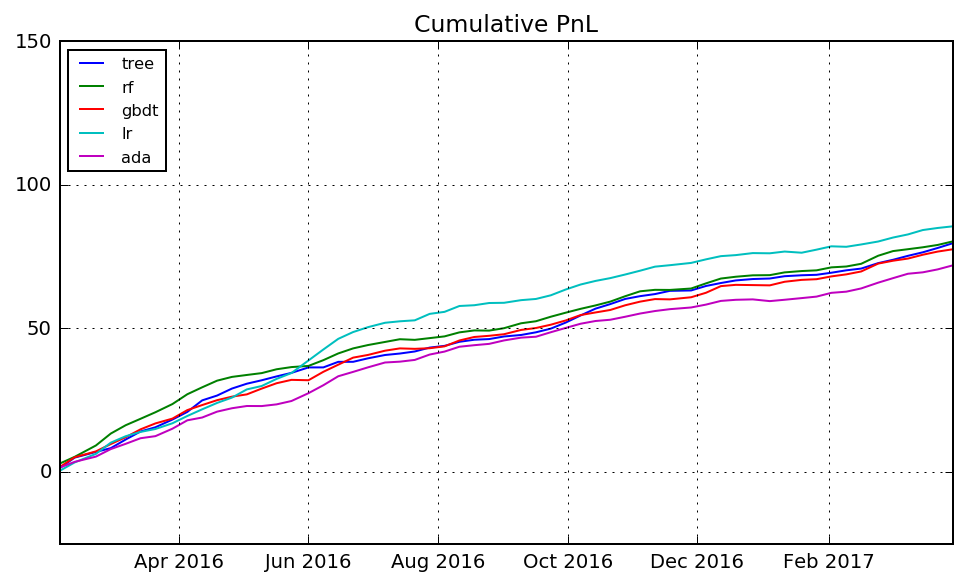

In [56]:
plt.figure(figsize=(8, 4.5))
for label in pnls:
    plt.plot(pnls[label][pnls[label] != 0].cumsum(), label=label)
#plt.plot()
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-25, 150)
plt.savefig('h:/rv-iv.png')
plt.show()

NameError: name 'pnl' is not defined

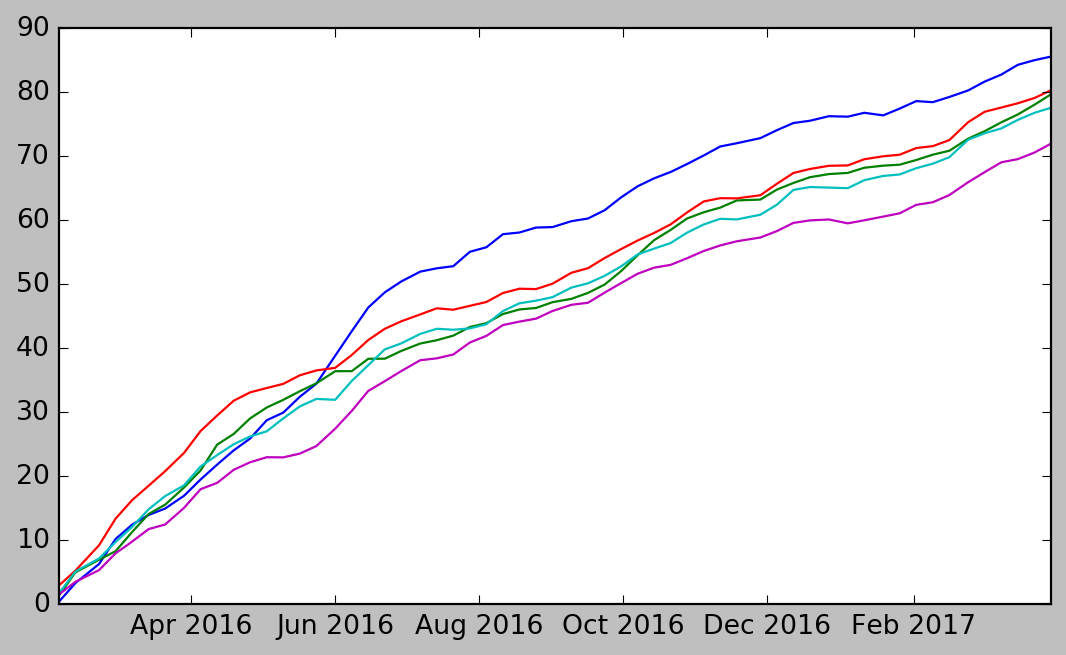

In [57]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnls['lr'].cumsum(), label='Logistic Regression')
plt.plot(pnls['tree'].cumsum(), label='Decision Tree')
plt.plot(pnls['rf'].cumsum(), label='Random Forest')
plt.plot(pnls['gbdt'].cumsum(), label='Gradient Boosting')
plt.plot(pnls['ada'].cumsum(), label='AdaBosst')
plt.plot(pnl.cumsum(), label='')
#plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True)
plt.ylim(-50, 100)
plt.savefig('h:/rv-iv.png')
#plt.show()

In [ ]:
performance = report_table([pnls['lr'], pnls['tree'], pnls['rf'], pnls['gbdt'], pnls['ada']], ['Logistic Regression', 'Decision Tree', 'Random Forest', "Gradient Boosting", 'AdaBoost'])
performance

In [ ]:
models['lr'].coef_